In [24]:
import numpy as np
import pandas as pd 
import os

In [25]:
# !pip install -U fastdup

In [26]:
import fastdup
fastdup.__version__

'0.133'

In [27]:
fastdup.run('/content/drive/MyDrive/Sea', work_dir='out')

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
Found existing atrain_features.dat file in the working directory, please remove it before running the program or run in a fresh directory.
If you like to resume a prevuously stopped run, please run with resume=1.


1

#Identify similar images

In [28]:
fastdup.create_duplicates_gallery('out/similarity.csv',save_path='.', num_images=20, get_label_func=lambda x: x.split('/')[-2])

100%|██████████| 20/20 [00:00<00:00, 39.86it/s]


Stored similarity visual view in  ./similarity.html



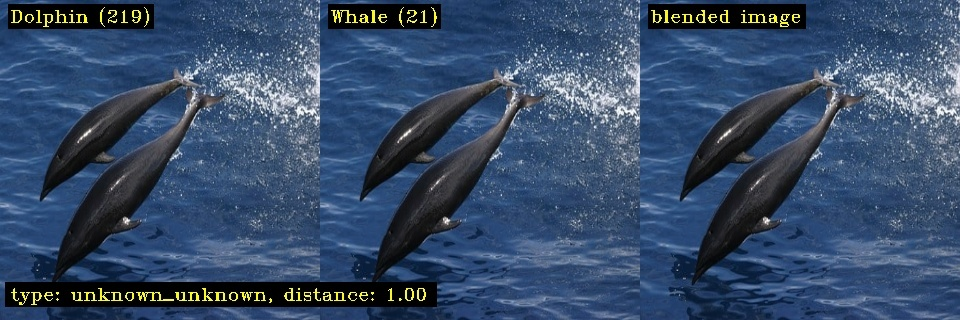
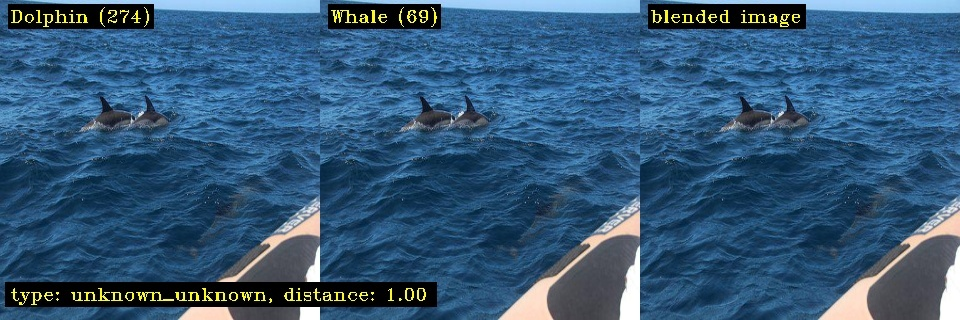
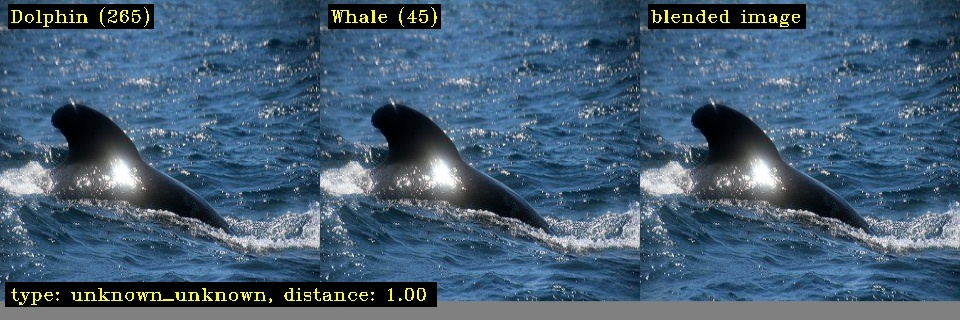
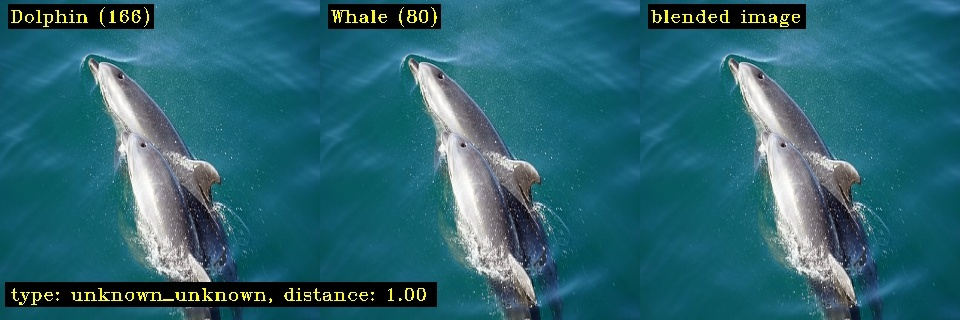
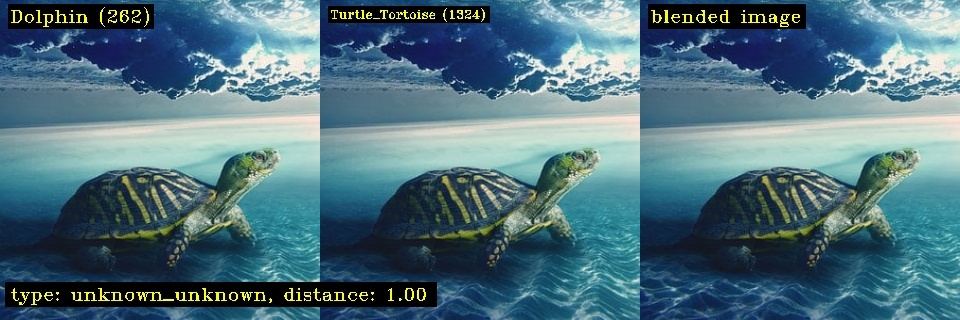
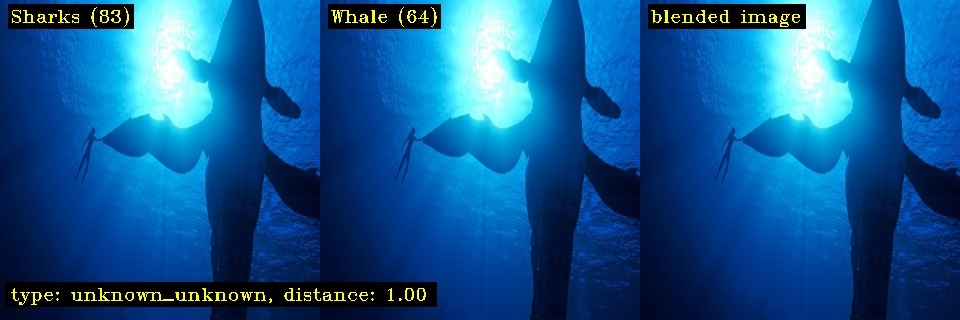
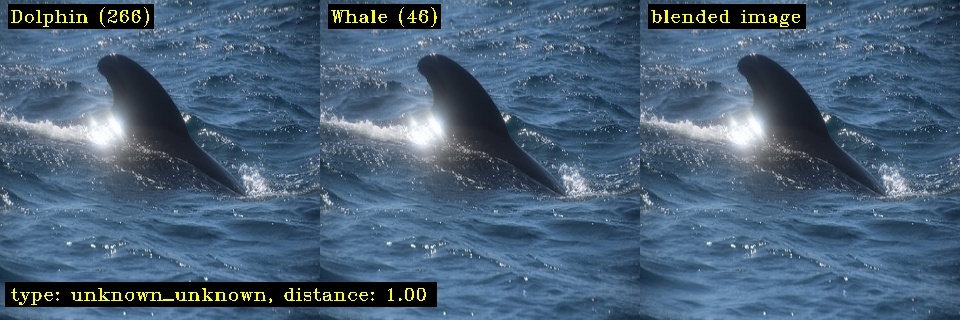
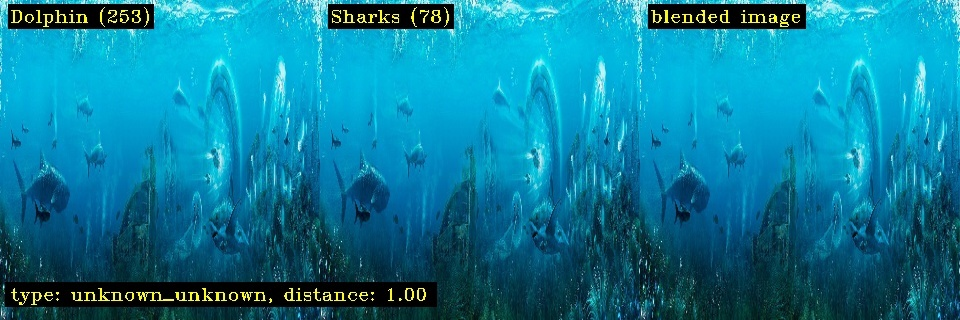
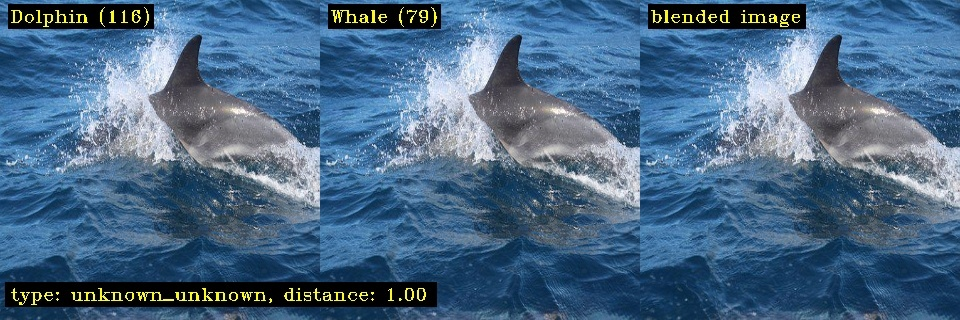
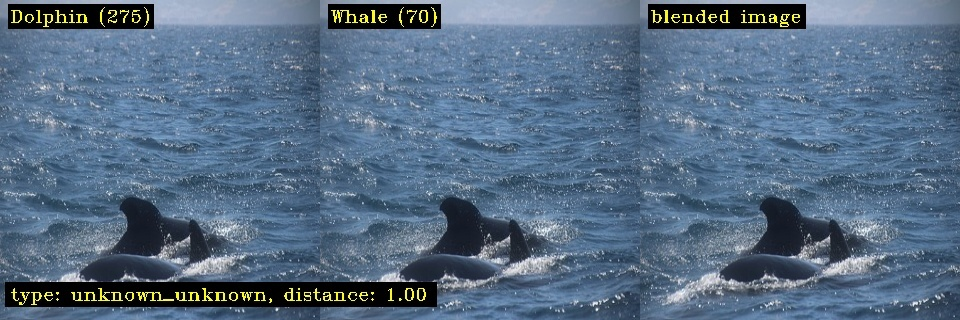
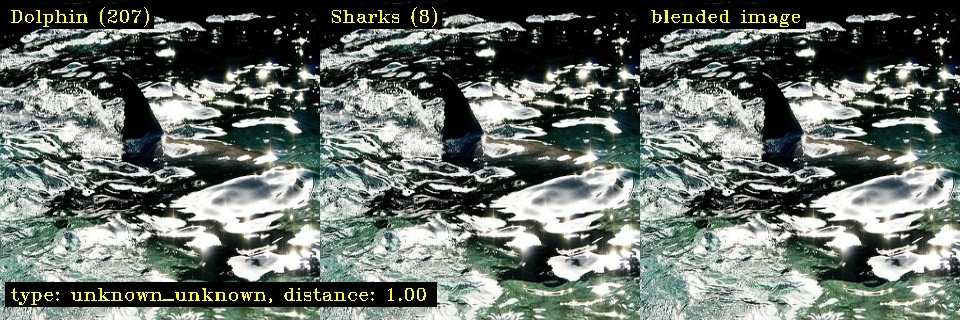
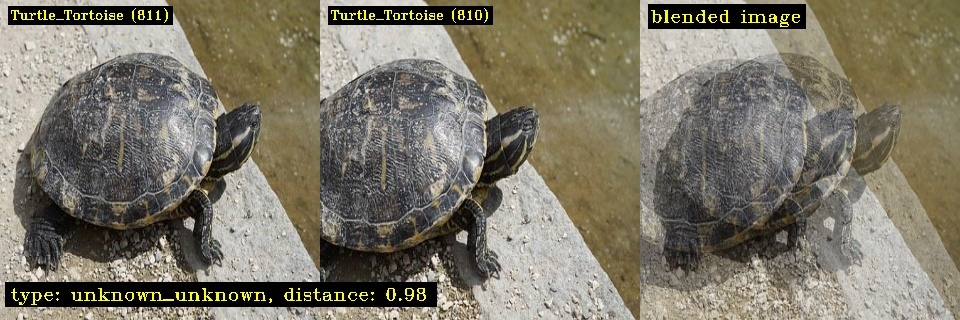
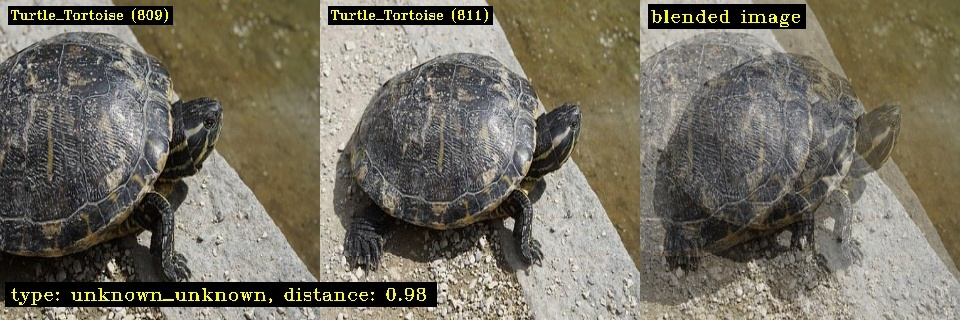
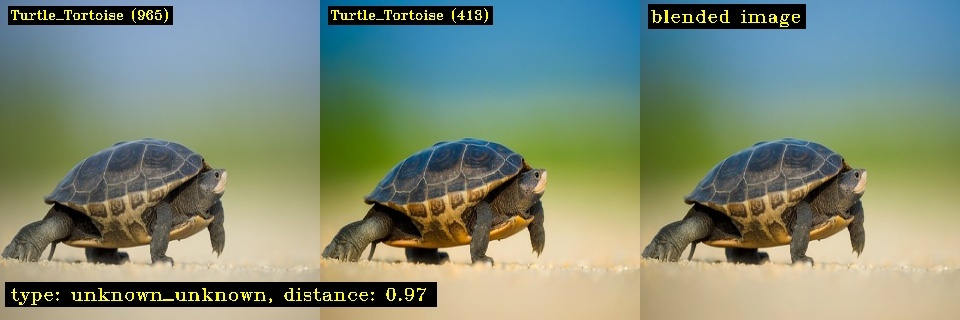
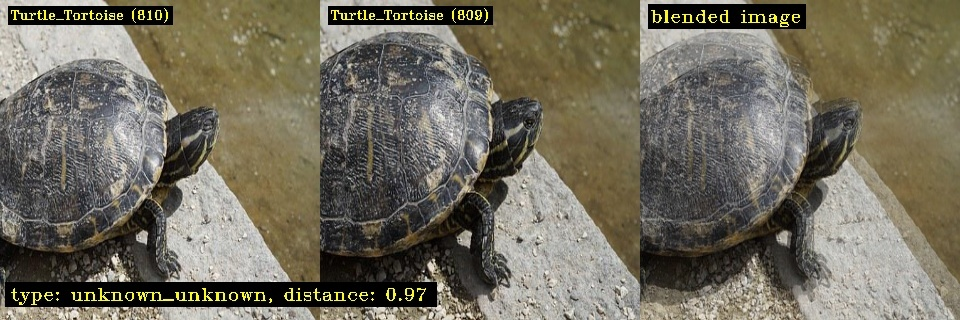

In [29]:
from IPython.display import HTML
HTML('similarity.html')

#Find darkest images

100%|██████████| 10/10 [00:00<00:00, 53.84it/s]


Stored mean statistics view in  ./mean.html



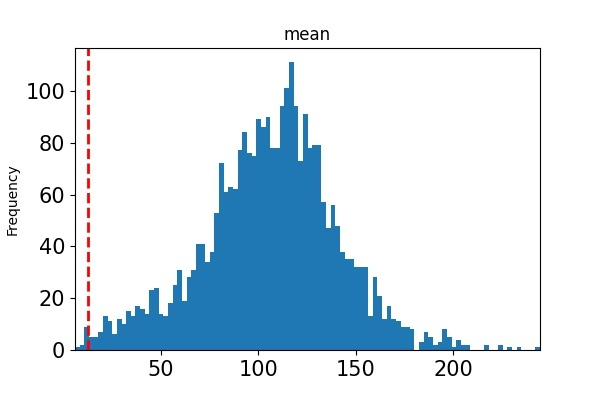
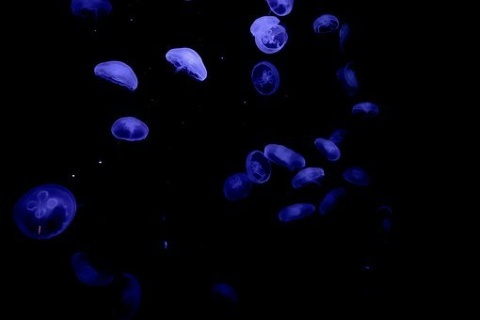
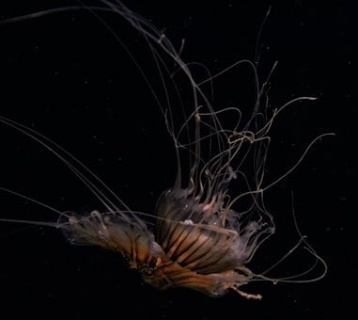
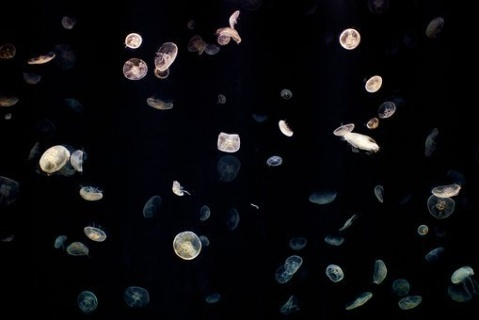
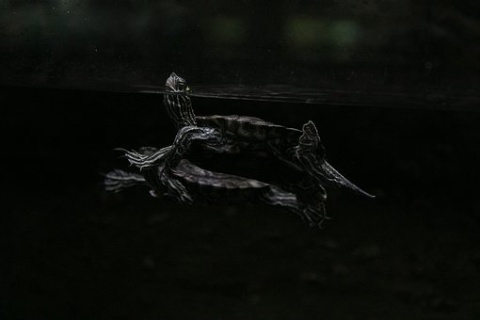
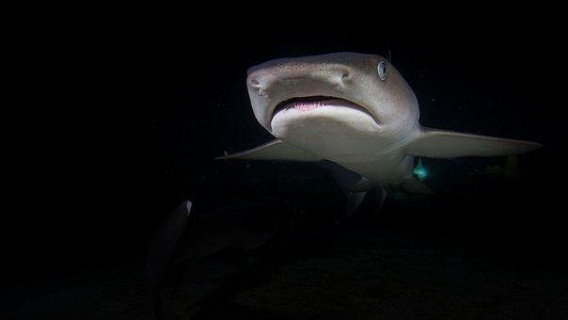
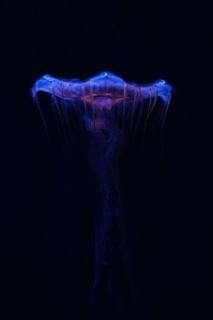
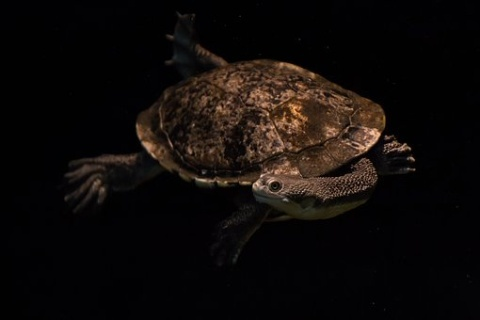
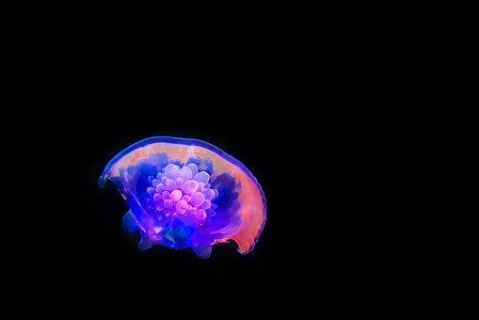
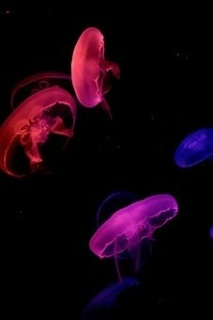
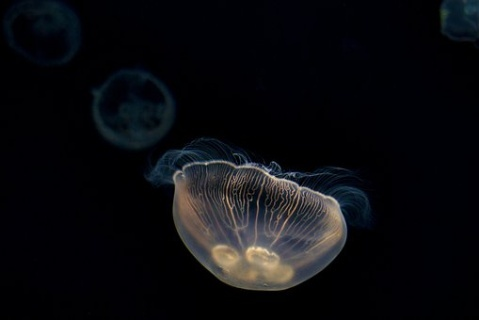

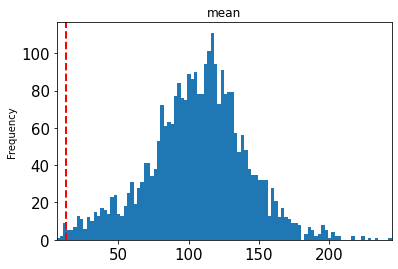

In [30]:
fastdup.create_stats_gallery('out',save_path='.', num_images=10, metric='mean',get_label_func=lambda x: x.split('/')[-2])
HTML('./mean.html')

#Find brightest images

100%|██████████| 10/10 [00:00<00:00, 73.51it/s]


Stored mean statistics view in  ./mean.html



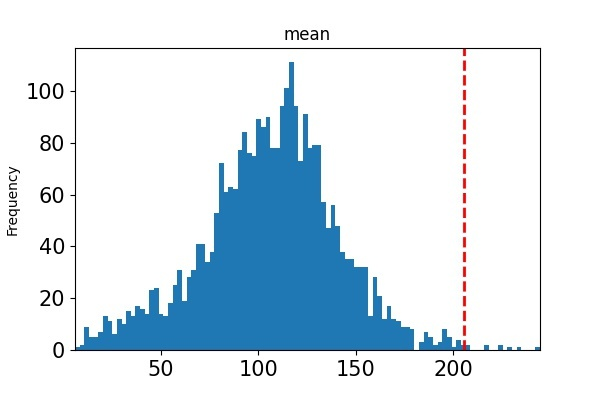
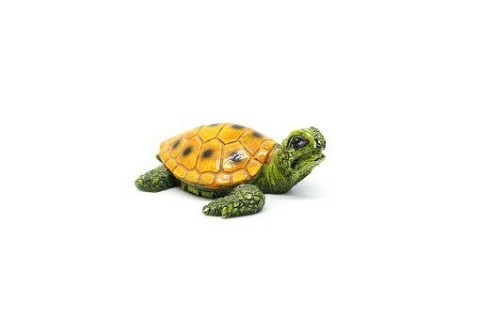
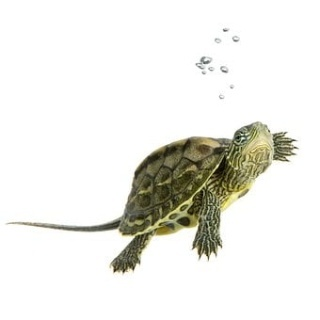
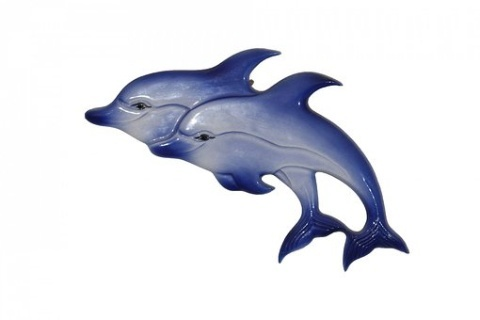
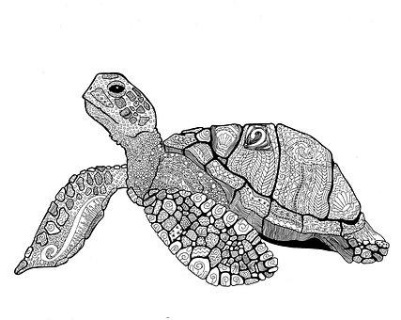
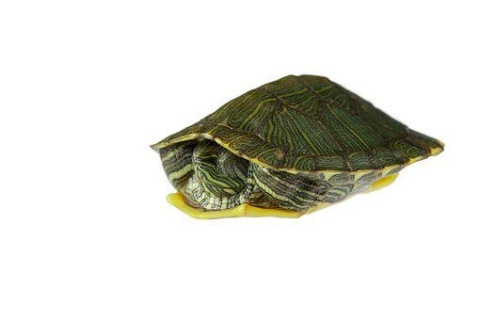
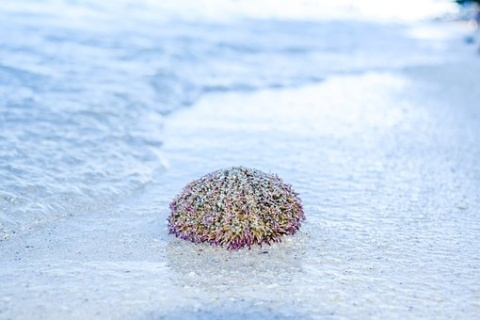
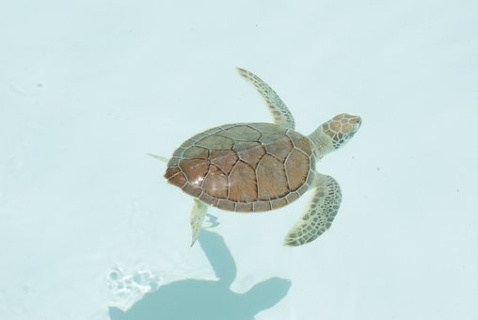
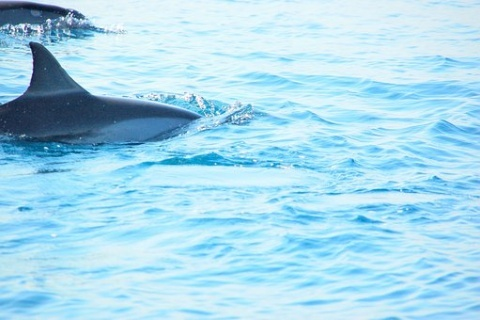
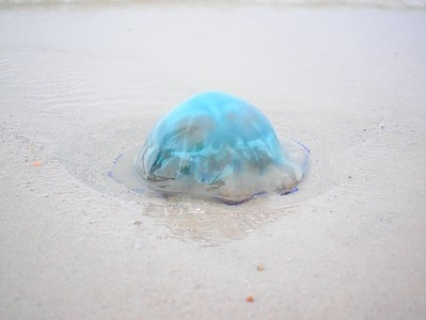
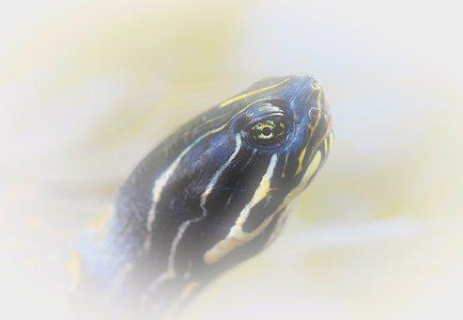

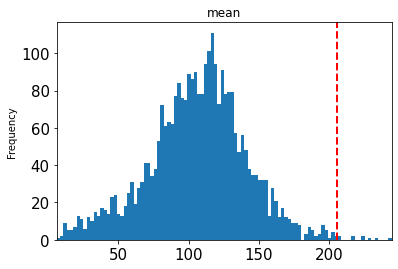

In [31]:
fastdup.create_stats_gallery('out',save_path='.', num_images=10, metric='mean',descending = True, get_label_func=lambda x: x.split('/')[-2])
HTML('mean.html')

#Find blurriest images

100%|██████████| 10/10 [00:00<00:00, 107.91it/s]

Stored blur statistics view in  ./blur.html



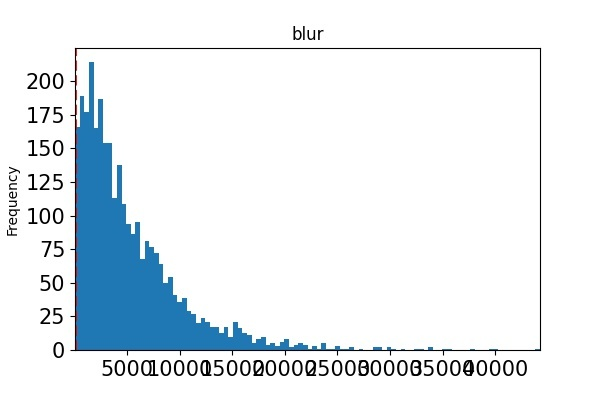
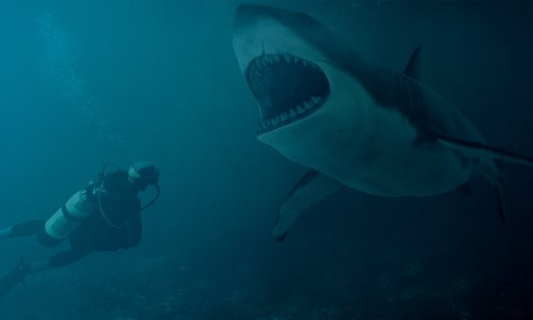
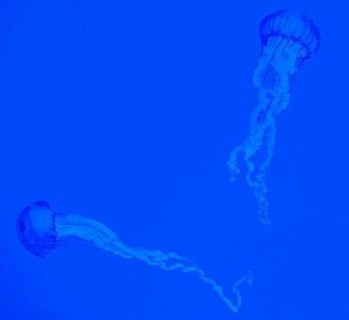
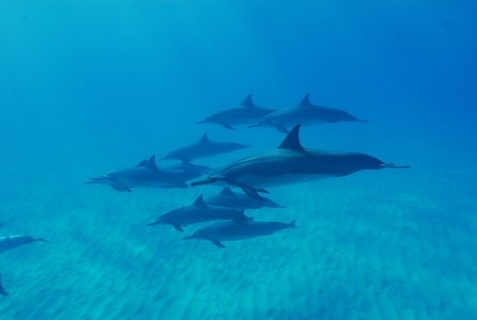
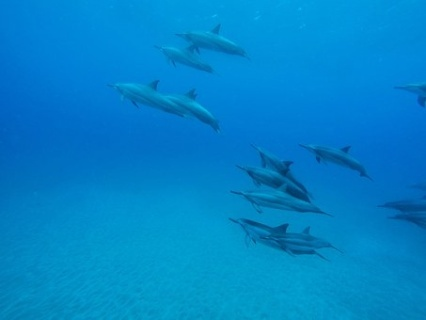
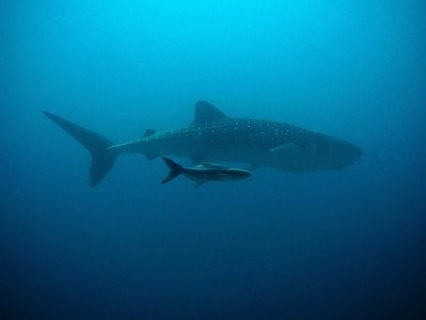
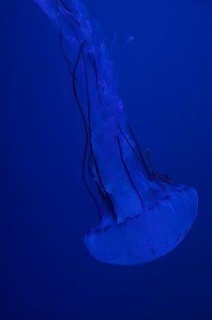
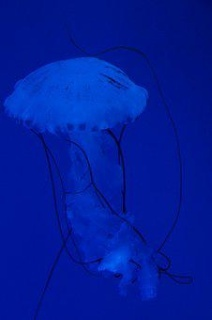
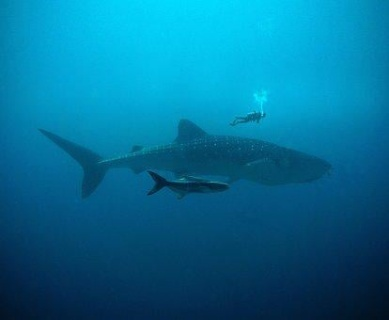
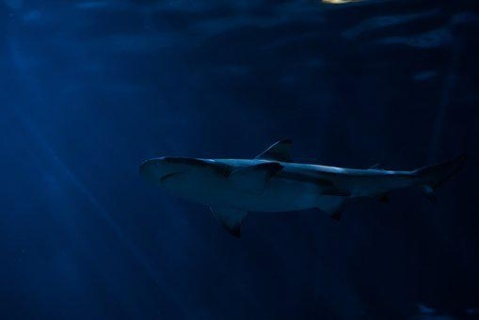
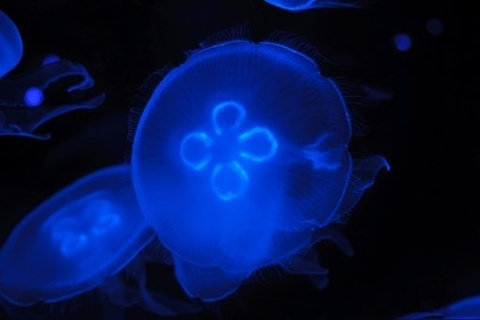

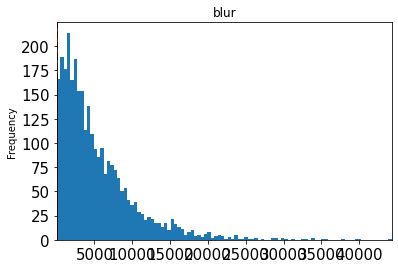

In [32]:
fastdup.create_stats_gallery('out',save_path='.', num_images=10, metric='blur',descending = False, get_label_func=lambda x: x.split('/')[-2])
HTML('blur.html')

#Find Potential label errors by finding instances similar to other classes

100%|██████████| 10/10 [00:00<00:00, 24.00it/s]


Stored similar images view in  ./topk_similarity.html



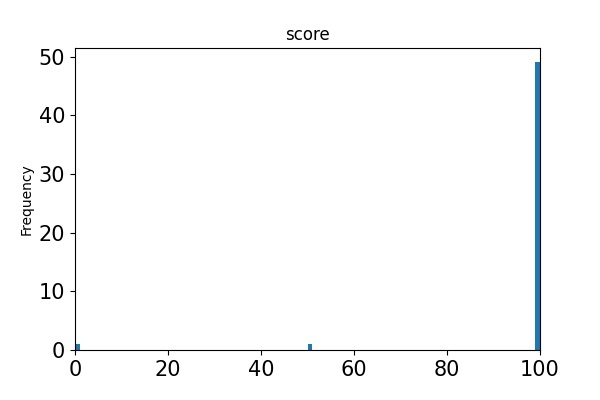
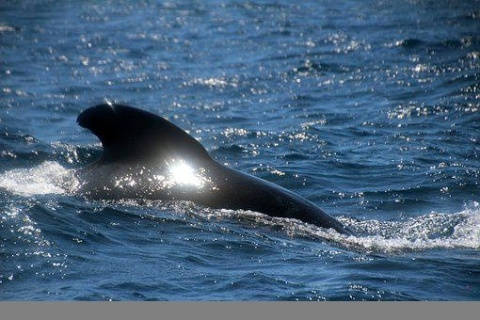
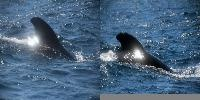
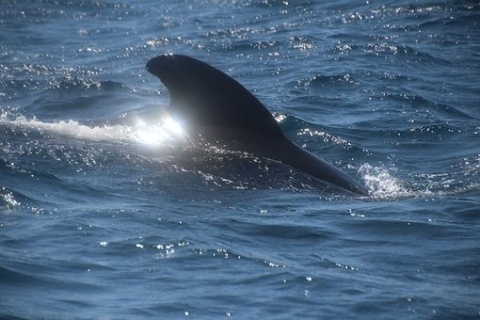
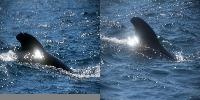
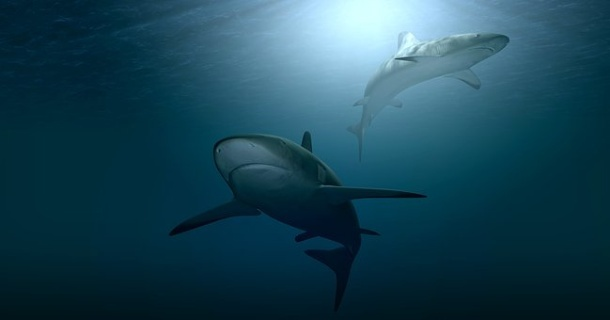
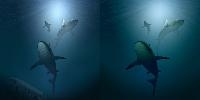
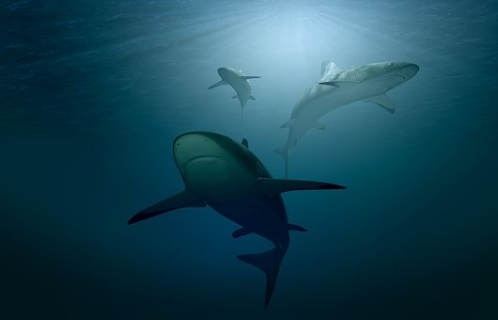
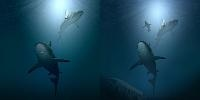
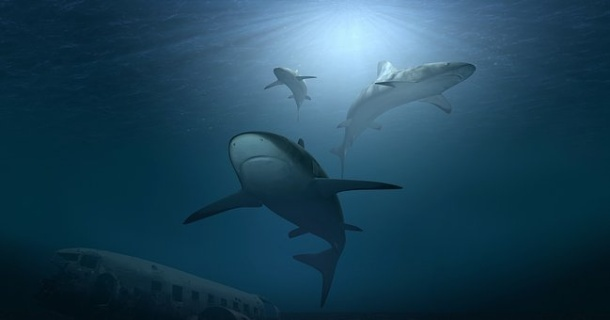
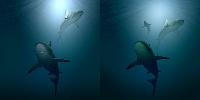
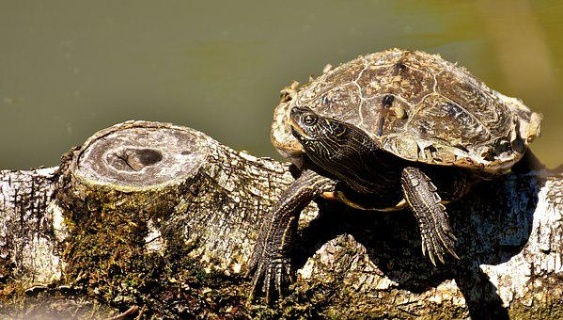
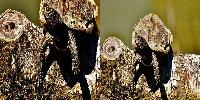
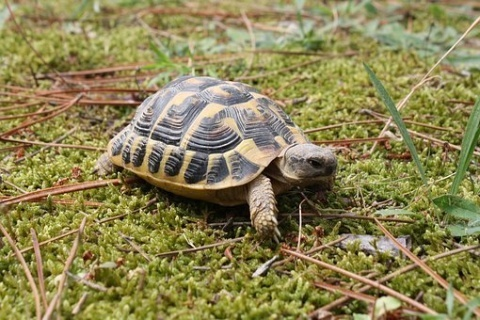
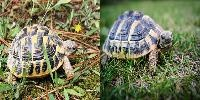
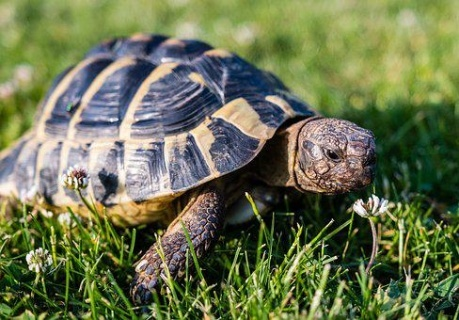
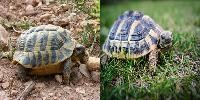
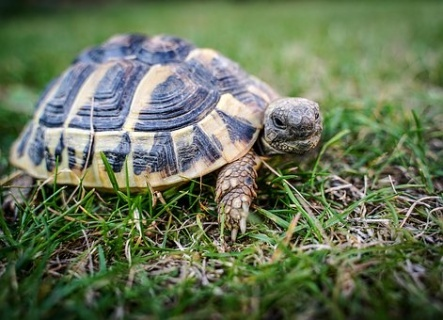
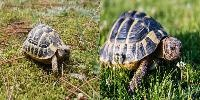
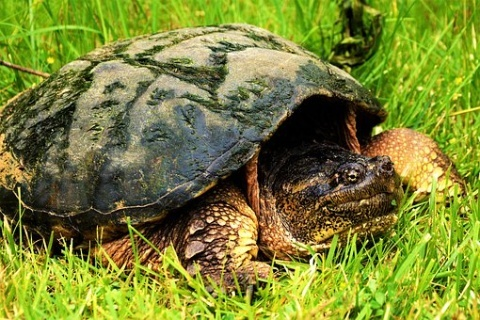
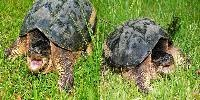

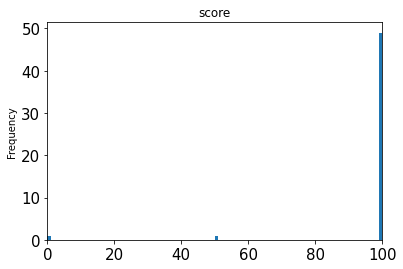

In [33]:
df2 = fastdup.create_similarity_gallery('out',save_path='.', num_images=10, get_label_func=lambda x: x.split('/')[-2], slice='label_score' )
HTML('topk_similarity.html')

#Now we relax the component threshold to 0.93 to group together similar images

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
Found existing atrain_features.dat file in the working directory, please remove it before running the program or run in a fresh directory.
If you like to resume a prevuously stopped run, please run with resume=1.


100%|██████████| 20/20 [00:00<00:00, 34.93it/s]


Finished OK. Components are stored as image files ./components_index_id.jpg
Stored components visual view in  ./components.html



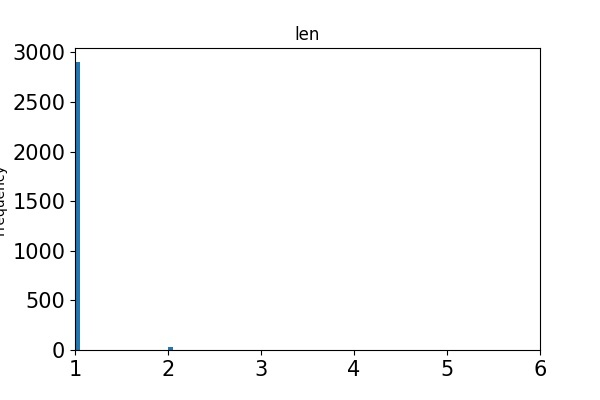
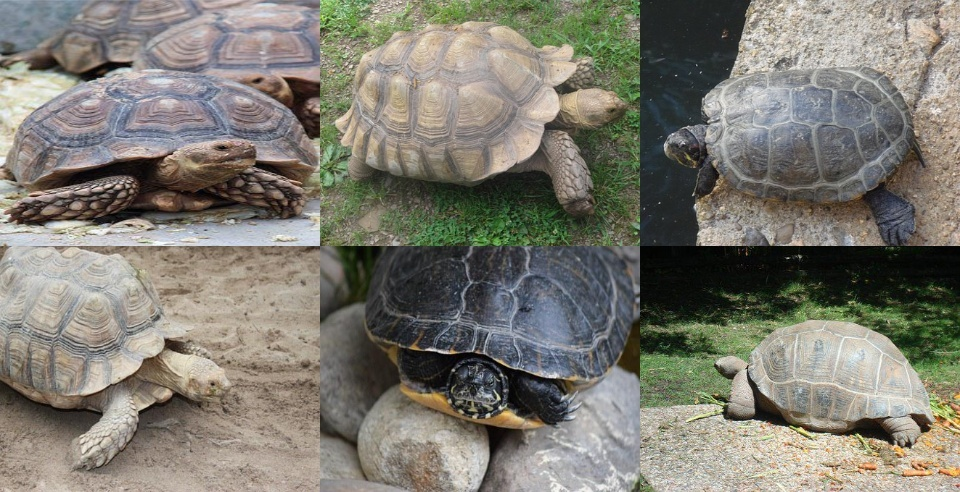
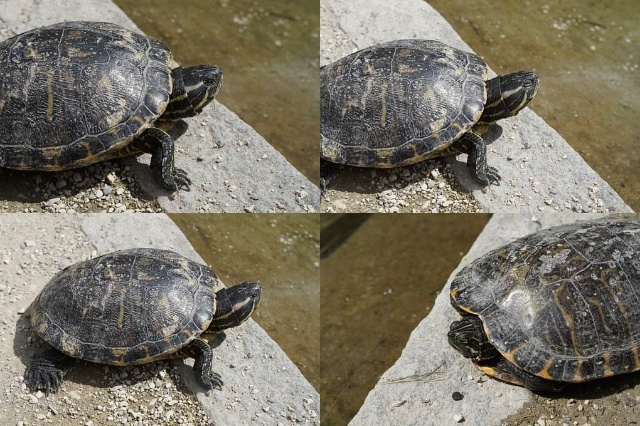
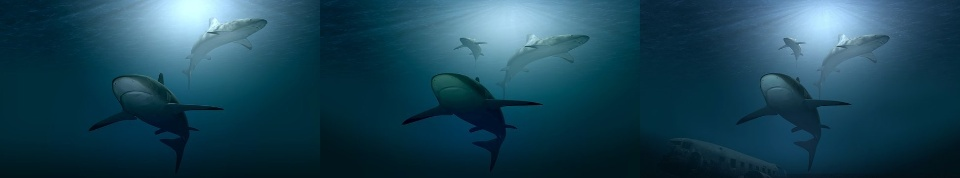
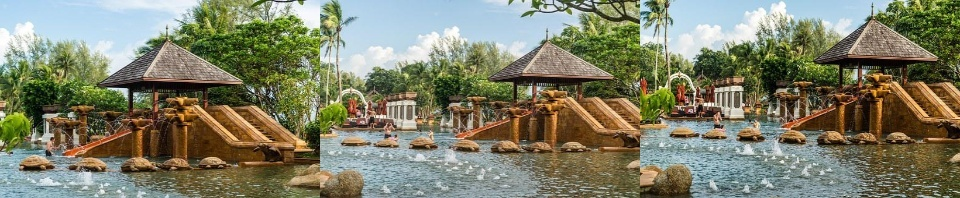
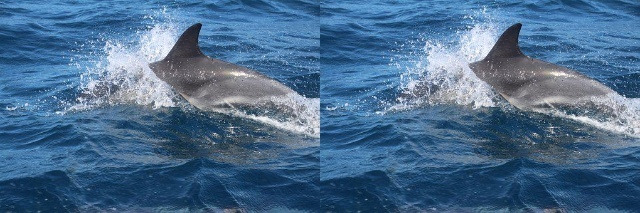
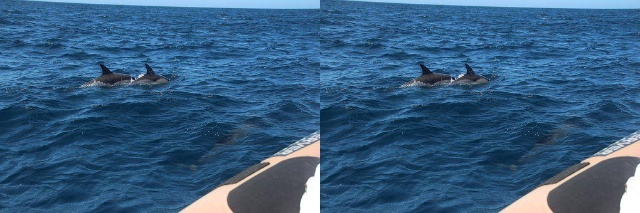
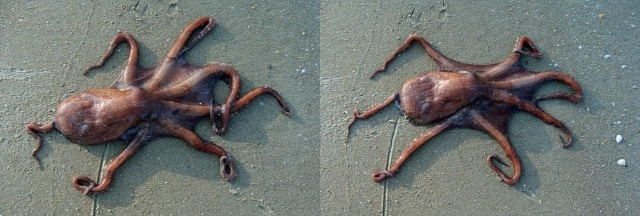
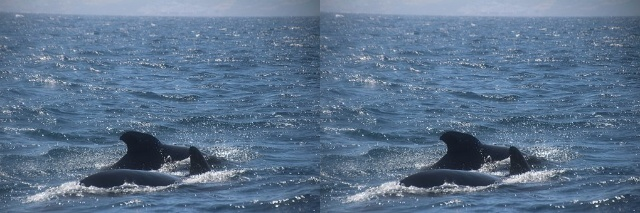
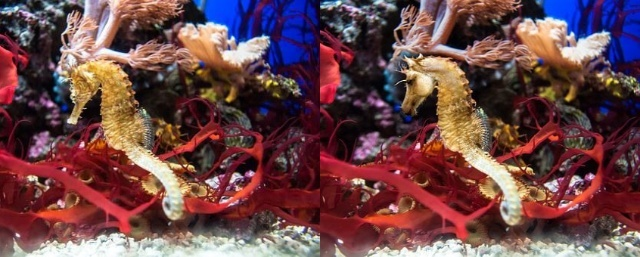
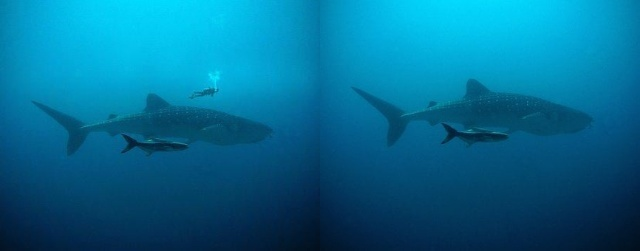
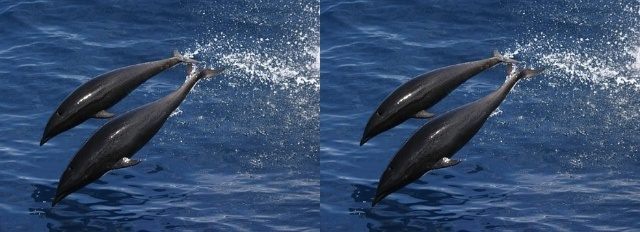
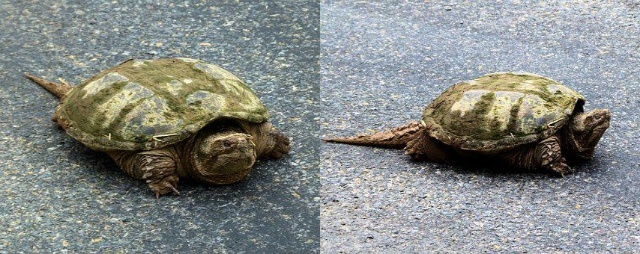
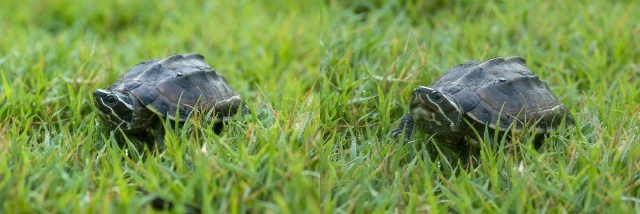
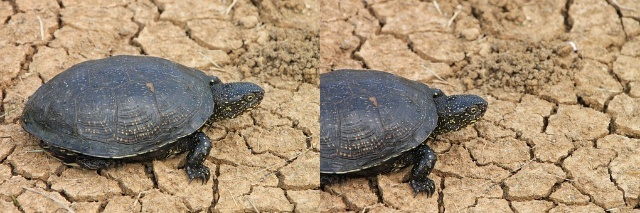
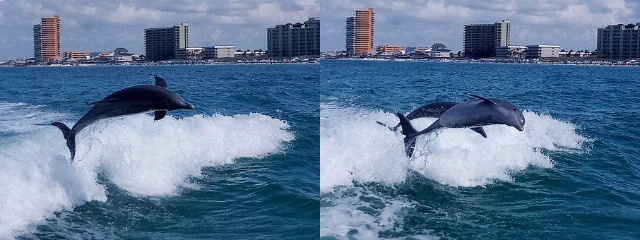
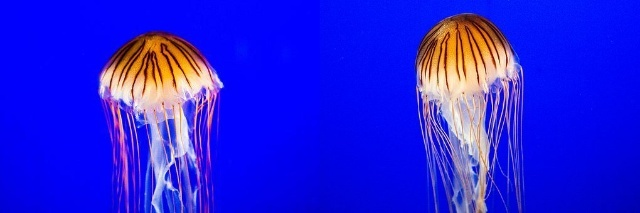
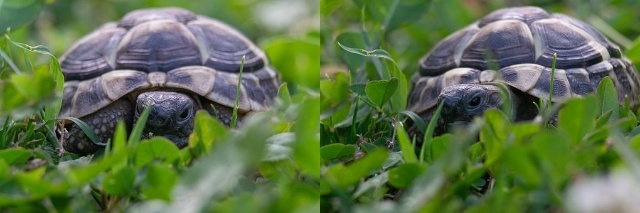
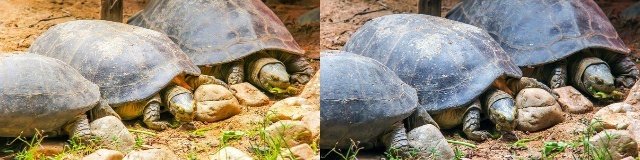
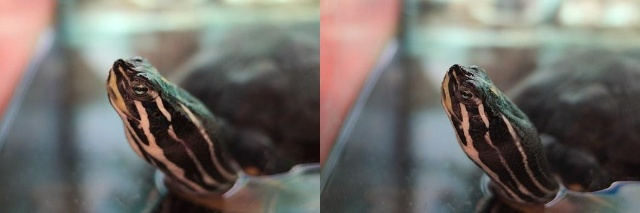
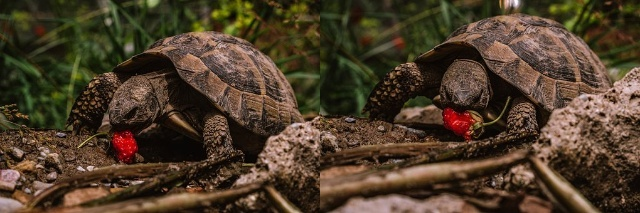

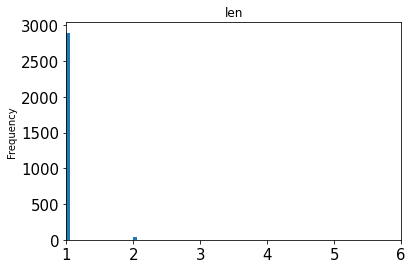

In [34]:
fastdup.run('/content/drive/MyDrive/Sea', work_dir='out2', turi_param='ccthreshold=0.93')
fastdup.create_components_gallery('out2','.', get_label_func=lambda x: x.split('/')[-2])
HTML('components.html')

#Remove all images from a component except for one

In [ ]:
top_components = fastdup.find_top_components('out2')
top_components = top_components[top_components['len'] > 1]
fastdup.delete_components(top_components, to_delete=list(top_components['component_id'].unique()), how='one', dry_run=True)

#Remove top 5% blurry images

In [ ]:
fastdup.delete_or_retag_stats_outliers('out2', metric='blur',how='delete', lower_percentile=0.05, dry_run=True)

#Remove images with confusing labels

Score of the confusing label is 0-> 100. We chose any images with score 50 or less, namely that has a nearest neighbor or two nearest neighbor from an opposite class.

In [37]:
fastdup.delete_or_retag_stats_outliers(df2, metric='score', filename_col = 'from', lower_threshold=51, dry_run=True)

Going to delete any images with score < 51
rm -f /content/drive/MyDrive/Sea/Dolphin/Dolphin (265).jpg
rm -f /content/drive/MyDrive/Sea/Dolphin/Dolphin (266).jpg


0

#Train a KNN classifier on the data

In [38]:
def top_k_label(labels_col, distance_col, k = 10, threshold = None,  min_count=None, unknown_class=None):
    assert len(labels_col), "Empty dataframe recevieved"
    df = pd.DataFrame({'labels':labels_col, 'distance':distance_col})
    
    if threshold is not None:
        df = df[df['distance'] >= threshold]
    
    ret = df.groupby('labels').agg('count')[['distance']]
    ret = ret.rename({'distance':'count'}, axis=1)
    ret2 = df.groupby('labels')['distance'].apply(list).to_frame()
    ret2 = ret2.rename({'distance':'distance_list'},axis=1)
    
    #print(ret)
    #print(ret2)
    ret = ret.join(ret2)
    ret = ret.sort_values('count', ascending=False)
    #print(ret)
    
    label = ret.index.values[0]
    count = ret['count'].values[0]
    if len(ret) == 1:
        return label
    else:
        second_label = ret.index.values[1]
        second_count = ret['count'].values[1]
        if min_count is not None and count >= min_count:
            return label
        
        if count > second_count:
            return label
        
        if unknown_class is None:
            return label


        return unknown_class

In [39]:
import pandas as pd
df = pd.DataFrame({'labels':['a','b','b'], 'distance':[1,2,3] })
print(top_k_label(df['labels'], df['distance'], k=3,min_count=2))

b


In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os

def create_knn_classifier(work_dir, k, get_label_func, threshold=None):
    similarity_file = os.path.join(work_dir, 'similarity.csv')
    df = pd.read_csv(similarity_file)
    df['to_label'] = df['to'].apply(get_label_func)
    
    from_list = df.groupby(by='from', axis=0)['to'].apply(list)
    distance_list = df.groupby(by='from', axis=0)['distance'].apply(list)
    to_label_list = df.groupby(by='from', axis=0)['to_label'].apply(list)

    df_from = from_list.to_frame()
    df_dist = distance_list.to_frame()
    df_label = to_label_list.to_frame()

    df_merge = df_from.merge(df_dist, on='from')
    df_merge = df_merge.merge(df_label, on='from')
    df_merge['from_label'] = df_merge.index.map(get_label_func)
    th = 0.6
  
    df_merge['top_k'] = df_merge.apply(lambda x: 
                                    top_k_label(x['to_label'], x['distance'], k, threshold), axis=1)

    y_values = df_merge['from_label'].tolist()
    #y_true = replace_values(y_values)
    
    p1_values = df_merge['top_k'].tolist()
    #y_pred = replace_values(p1_values)

    #target_names = ['unknown', 'known']
    print(classification_report(y_values, p1_values))
    
    return p1_values

#Run one vs. all KNN classifier

In [41]:
predictions = create_knn_classifier('out', k=2, get_label_func=lambda x: x.split('/')[-2])

                 precision    recall  f1-score   support

        Dolphin       0.89      0.65      0.76        26
     Jelly Fish       1.00      1.00      1.00         4
        Octopus       1.00      1.00      1.00         2
       Sea Rays       1.00      1.00      1.00         2
    Sea Urchins       1.00      1.00      1.00         4
       Seahorse       1.00      1.00      1.00         2
         Sharks       0.78      0.78      0.78         9
Turtle_Tortoise       0.99      1.00      1.00       132
          Whale       0.30      0.75      0.43         4

       accuracy                           0.94       185
      macro avg       0.88      0.91      0.88       185
   weighted avg       0.95      0.94      0.94       185



#Let's improve performance by removing confusing examples

In [43]:
fastdup.delete_or_retag_stats_outliers(df2, metric='score', filename_col = 'from', lower_threshold=51, dry_run=False, 
                                       get_reformat_filename_func=lambda x: x.replace('/content/drive/MyDrive/Sea','/content/drive/MyDrive/Sea'))

Going to delete any images with score < 51
total deleted 2 files


0

#Train again the model without the confusing examples

In [44]:
fastdup.run('/content/drive/MyDrive/Sea', work_dir='out3')

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
On Jupyter notebook running on large datasets, there may be delay getting the console output. We recommend running using python shell.


0

In [45]:
predictions = create_knn_classifier('out3', k=2, get_label_func=lambda x: x.split('/')[-2])

                 precision    recall  f1-score   support

        Dolphin       0.94      0.67      0.78        24
     Jelly Fish       1.00      1.00      1.00         4
        Octopus       1.00      1.00      1.00         2
       Sea Rays       1.00      1.00      1.00         2
    Sea Urchins       1.00      1.00      1.00         4
       Seahorse       1.00      1.00      1.00         2
         Sharks       0.78      0.78      0.78         9
Turtle_Tortoise       0.99      1.00      1.00       132
          Whale       0.40      1.00      0.57         4

       accuracy                           0.95       183
      macro avg       0.90      0.94      0.90       183
   weighted avg       0.96      0.95      0.95       183

